In [22]:
#Codice dell'agente DQN
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from collections import deque
import numpy as np
import random
import os

class DQNAgent():
    def __init__(self, env, iterations=200, load=False, alpha= 0.001, epsilon=1.0, gamma=0.99, model_name="cervello_positronico"):
        #variabili dell'ambiente
        self.env = env
        self.state_size = self.env.observation_space.shape[0]
        self.action_size = self.env.action_space.n
        self.state_shape = self.env.observation_space.shape
        self.max_iterations = iterations

        #replay memory e campione
        self.memory = deque(maxlen=20_000)
        self.mem_sample = 32

        #learning rate
        self.alpha = alpha

        #exploration
        self.epsilon = epsilon
        self.epsilon_min = 0.01
        self.epsilon_reduction = 0.05

        #futuro 
        self.gamma = gamma

        #creazione delle due reti neurali, quella dell'addestramento e quella stabile
        self.model_name = model_name
        self.train_model = self.create_model(load)
        self.target_model = self.create_model(False)
        self.target_model.set_weights(self.train_model.get_weights())

    def create_model(self, load):
        model = Sequential()
        model.add(Dense(24, input_shape=self.state_shape, activation='relu'))
        model.add(Dense(48, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))

        model.compile(loss='mse', optimizer=Adam(lr=self.alpha))
        if load:
            model.load_weights(self.model_name)

        return model

    #scelta dell'azione in base ad epsilon
    def choose_action(self, state):
        if random.uniform(0,1) < self.epsilon:
            return self.env.action_space.sample()
        else:
            return np.argmax(self.train_model.predict(state)[0])

    def train_from_memory(self):
        if len(self.memory) < self.mem_sample:
            return

        minibatch = random.sample(self.memory, self.mem_sample)

        states = []
        new_states=[]

        for state, _, _, new_state, _ in minibatch:
            states.append(state)
            new_states.append(new_state)
        
        states = np.array(states).reshape(self.mem_sample, 2)
        new_states = np.array(new_states).reshape(self.mem_sample, 2)

        targets = self.train_model.predict(states)
        new_state_targets=self.target_model.predict(new_states)

        i=0
        for state, action, reward, new_state, done in minibatch:
            target = targets[i]
            if done:
                target[action] = reward
            else:
                target[action] = reward + self.gamma * np.max(new_state_targets[i])
            i+=1
        
        self.train_model.fit(states, targets, epochs=1, verbose=0)

    #salvataggio del cervellone
    def save_model(self, name):
        self.train_model.save(name)

    def load_model(self, name):
        target_model.load_weights(name)
        train_model.load_weights(name)

    #memorizzazione degli stati
    def memorize(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def fit(self, episode, state, render):
        total_reward = 0
        record = self.env.observation_space.low[0]

        for epoch in range(self.max_iterations):
            if render and episode % 50 == 0:
                self.env.render()
            
            action = self.choose_action(state)
            new_state, reward, done, _ = self.env.step(action)
            new_state = state.reshape(1,self.state_size)

            if new_state[0][0] > record:
                record = new_state[0][0]

            if new_state[0][0] >= 0.5:
                reward += 10

            total_reward += reward

            self.memorize(state, action, reward, new_state, done)
            self.train_from_memory()

            state = new_state

            if done:
                break

        if epoch >= self.max_iterations - 1:
            print("Failed to finish task in epsoide {}".format(episode))
        else:
            print("Success in epsoide {}, used {} iterations!".format(episode,epoch))
            self.save_model('train_model_in_epi{}.h5'.format(episode))

        #Sync
        self.target_model.set_weights(self.train_model.get_weights())

        print("--now epsilon is {}, the reward is {} maxPosition is {}".format(self.epsilon, total_reward,record))

        if self.epsilon > self.epsilon_min:
            self.epsilon -= self.epsilon_reduction

        return total_reward, epoch
    
    def start_training(self, episodes=400, render=False):
        total_rewards=[]
        total_epochs=[]
        
        for episode in range(episodes):
            state = env.reset().reshape(1,self.state_size)
            total_reward, epoch = self.fit(episode, state, render)

            total_epochs.append(epoch)
            total_rewards.append(total_reward)
        
        return total_rewards, total_epochs

    def play(self, trials):
        epochs = []
        done = False
        state = self.env.reset().reshape(state, (1, self.state_size))

        for episode in range(episodes):
            successes = 0
            for i in range(self.max_iterations):
                self.env.render()
                action = np.argmax(self.target_model.predict(state))

                next_state, reward, done, _ = self.env.step(action)
                next_state = np.reshape(next_state, (1, self.state_size))

                if done:
                    successes += 1
                state = next_state
            
            epochs.append(i)

        return epochs, successes

In [23]:
import gym

#creazione dell'ambiente e dell'agente
env = gym.make('MountainCar-v0')
pippo = DQNAgent(env)
#addestramento del pilota Pippo
total_rewards, total_epochs = pippo.start_training(400, True)

6, the reward is -200.0 maxPosition is -0.5833763917719212
Failed to finish task in epsoide 453
--now epsilon is -3.191891195797325e-16, the reward is -200.0 maxPosition is -0.4138508946594599
Success in epsoide 454, used 134 iterations!
--now epsilon is -3.191891195797325e-16, the reward is -135.0 maxPosition is -0.4924075774056542
Failed to finish task in epsoide 455
--now epsilon is -3.191891195797325e-16, the reward is -200.0 maxPosition is -0.491654144276188
Failed to finish task in epsoide 456
--now epsilon is -3.191891195797325e-16, the reward is -200.0 maxPosition is -0.4972595895471702
Success in epsoide 457, used 173 iterations!
--now epsilon is -3.191891195797325e-16, the reward is -174.0 maxPosition is -0.5211164520515171
Failed to finish task in epsoide 458
--now epsilon is -3.191891195797325e-16, the reward is -200.0 maxPosition is -0.4531324890562347
Failed to finish task in epsoide 459
--now epsilon is -3.191891195797325e-16, the reward is -200.0 maxPosition is -0.42360

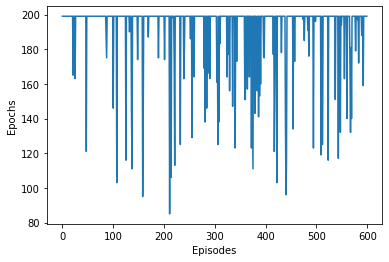

In [26]:
import matplotlib.pyplot as plt

plt.xlabel("Episodes")
plt.ylabel("Epochs")
plt.plot(range(600), total_epochs)

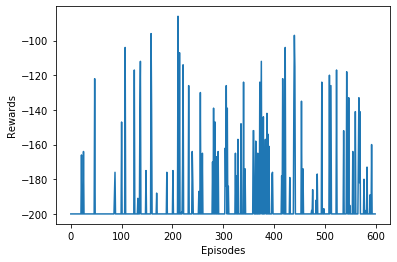

In [27]:
plt.xlabel("Episodes")
plt.ylabel("Rewards")
plt.plot(range(600), total_rewards)

In [29]:
#test del pilota
epochs, successes = pippo.play(5)

UnboundLocalError: local variable 'state' referenced before assignment

In [21]:
plt.xlabel("Episodes")
plt.ylabel("Rewards")
plt.plot(range(epochs), total_rewards)

In [37]:
pippo.save_model("./pino.h5")